# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [92]:
import pandas as pd
import numpy as np

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [93]:
from sklearn.model_selection import train_test_split

y = df['salary_in_usd']
X = df.drop(columns=['salary_in_usd', 'salary', 'salary_currency'])

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)


## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']

encoder = OneHotEncoder(handle_unknown="ignore")
X_train_enc = encoder.fit_transform(X_train[categorical_features])
X_val_enc = encoder.transform(X_val[categorical_features])
X_test_enc = encoder.transform(X_test[categorical_features])

model = LinearRegression()
model.fit(X_train_enc, y_train)
y_pred = model.predict(X_test_enc)

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred) * 100)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

MAPE:  36.940718943611046
RMSE:  51730.923719902275


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [95]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
import time

params = {
    'max_depth' : [3, 5, 7],
    'learning_rate' :[ 0.1, 0.2, 0.3],
    'n_estimators' : [50, 100, 200],
    'gamma' : [0, 0.1, 0.2],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}
model = XGBRegressor(random_state=42, n_jobs=-1)
search = GridSearchCV(
    estimator=model,
    param_grid=params,
    cv=3,
    scoring='neg_mean_absolute_percentage_error',
    verbose=0,
    n_jobs=-1
)
start_time = time.time()
search.fit(X_val_enc, y_val)
print(f"Поиск занял {time.time() - start_time:.2f} сек.")

best_params = search.best_params_
best_xgb = XGBRegressor(**best_params, random_state=42, n_jobs=-1)

start_time = time.time()
best_xgb.fit(X_train_enc, y_train)
y_pred = best_xgb.predict(X_test_enc)
pred_time = time.time() - start_time

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred) * 100)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"Время предсказания: {pred_time:.4f} сек.")

Поиск занял 51.74 сек.
MAPE:  34.940168261528015
RMSE:  50106.45946382562
Время предсказания: 0.3968 сек.


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [96]:
from catboost import CatBoostRegressor

params_cat = {
    'depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.3],
    'iterations': [100, 200],
    'l2_leaf_reg': [0.5, 1, 3]
}

model_cat = CatBoostRegressor(silent=True, random_state=42)

grid_search_cat = GridSearchCV(
    estimator=model_cat,
    param_grid=params_cat,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=0
)

grid_search_cat.fit(X_val_enc, y_val)

best_params_cat = grid_search_cat.best_params_
best_cat = CatBoostRegressor(**best_params_cat)

start_train = time.time()
best_cat.fit(X_train_enc, y_train)
train_cat = time.time() - start_train

start_pred = time.time()
y_pred_cat = best_cat.predict(X_test_enc)
pred_cat = time.time() - start_pred

rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
mape_cat = mean_absolute_percentage_error(y_test, y_pred_cat)

0:	learn: 61941.4982979	total: 4.79ms	remaining: 474ms
1:	learn: 60852.7817101	total: 8.46ms	remaining: 414ms
2:	learn: 60046.8344061	total: 15.1ms	remaining: 490ms
3:	learn: 59174.9934134	total: 17.8ms	remaining: 428ms
4:	learn: 58334.3314933	total: 25.6ms	remaining: 486ms
5:	learn: 57667.0758101	total: 32.6ms	remaining: 511ms
6:	learn: 56972.9788387	total: 36ms	remaining: 478ms
7:	learn: 56334.0914138	total: 42.6ms	remaining: 490ms
8:	learn: 55732.0824869	total: 49.6ms	remaining: 501ms
9:	learn: 55149.3523630	total: 55.6ms	remaining: 500ms
10:	learn: 54722.7667109	total: 60.9ms	remaining: 493ms
11:	learn: 54252.9788406	total: 65.1ms	remaining: 477ms
12:	learn: 53869.9048424	total: 71.8ms	remaining: 481ms
13:	learn: 53451.6668364	total: 77.8ms	remaining: 478ms
14:	learn: 53143.2001896	total: 80.9ms	remaining: 458ms
15:	learn: 52818.5264037	total: 84.7ms	remaining: 445ms
16:	learn: 52505.4636748	total: 90.8ms	remaining: 444ms
17:	learn: 52214.9171148	total: 96.7ms	remaining: 441ms
18:	

In [97]:
print(f"Время обучения: {train_cat:.2f} сек")
print(f"Время предсказания: {pred_cat:.4f} сек")
print('MAPE: ', round(mape_cat,3))
print('RMSE: ', round(rmse_cat,3))

Время обучения: 0.52 сек
Время предсказания: 0.0023 сек
MAPE:  0.37
RMSE:  50776.044


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [98]:
from catboost import Pool

train_pool = Pool(data=X_train,
                 label=y_train,
                 cat_features=categorical_features)

test_pool = Pool(data=X_test,
               label=y_test,
               cat_features=categorical_features)

params_pool = {
    'depth': [3, 5, 7],
    'learning_rate': [0.05, 0.01, 0.3],
    'iterations': [100, 500],
    'l2_leaf_reg': [0.5, 1, 3]
}

model_pool= CatBoostRegressor(silent=True, random_state=42)

grid_search_pool = GridSearchCV(
    estimator=model_pool,
    param_grid=params_pool,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=0
)

grid_search_pool.fit(X_val, y_val, cat_features=categorical_features)

best_params_pool = grid_search_cat.best_params_
best_pool = CatBoostRegressor(**best_params_pool)

start_train = time.time()
best_pool.fit(train_pool)
train_pool = time.time() - start_train

start_pred = time.time()
y_pred_pool = best_pool.predict(test_pool)
pred_pool = time.time() - start_pred

rmse_pool = np.sqrt(mean_squared_error(y_test, y_pred_pool))
mape_pool = mean_absolute_percentage_error(y_test, y_pred_pool)

0:	learn: 62485.7264082	total: 2.06ms	remaining: 203ms
1:	learn: 61747.2153266	total: 5.91ms	remaining: 290ms
2:	learn: 61131.3520851	total: 9.46ms	remaining: 306ms
3:	learn: 60600.7471103	total: 11.7ms	remaining: 282ms
4:	learn: 60112.0418601	total: 14.7ms	remaining: 279ms
5:	learn: 59359.8903788	total: 16.3ms	remaining: 256ms
6:	learn: 58663.0006720	total: 18.4ms	remaining: 245ms
7:	learn: 58063.5570532	total: 19.6ms	remaining: 225ms
8:	learn: 57459.3073874	total: 22.2ms	remaining: 224ms
9:	learn: 56890.8664617	total: 25ms	remaining: 225ms
10:	learn: 56398.5246634	total: 27.1ms	remaining: 219ms
11:	learn: 55954.8858452	total: 28.6ms	remaining: 209ms
12:	learn: 55499.6392190	total: 31.2ms	remaining: 209ms
13:	learn: 55060.2663654	total: 34ms	remaining: 209ms
14:	learn: 54709.3996221	total: 35.5ms	remaining: 201ms
15:	learn: 54375.5403869	total: 38.1ms	remaining: 200ms
16:	learn: 54083.0462800	total: 40.7ms	remaining: 199ms
17:	learn: 53805.8349908	total: 43.4ms	remaining: 198ms
18:	le

In [99]:
print(f"Время обучения: {train_pool:.2f} сек")
print(f"Время предсказания: {pred_pool:.4f} сек")
print('MAPE: ', round(mape_pool, 3))
print('RMSE: ', round(rmse_pool, 3))

Время обучения: 0.30 сек
Время предсказания: 0.0008 сек
MAPE:  0.365
RMSE:  49940.128


**Ответ:** Да, время обучения уменьшилось почти в два раза, а время предсказания еще больше, также ошибки стали немного меньше

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [100]:
from lightgbm import LGBMRegressor

params_lgb = {
    'max_depth': [2, 4, 6],
    'learning_rate': [0.05, 0.1, 0.3],
    'n_estimators': [10, 20, 50],
    'num_leaves': [5, 10, 15],
    'min_child_samples': [5, 10],
    'feature_fraction': [0.8, 0.9],
}

model_lgb = LGBMRegressor(verbose=-1, random_state=42)

search = GridSearchCV(
    estimator=model_pool,
    param_grid=params_pool,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=0
)
search.fit(X_val_enc, y_val)

best_lgb = search.best_estimator_
best_params = search.best_params_

start_train = time.time()
best_lgb.fit(X_train_enc, y_train)
train_lgb = time.time() - start_train

start_pred = time.time()
y_pred_lgb = best_lgb.predict(X_test_enc)
pred_lgb = time.time() - start_pred

rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb)

In [101]:
print(f"Время обучения: {train_lgb:.2f} сек")
print(f"Время предсказания: {pred_lgb:.4f} сек")
print('MAPE: ', round(mape_lgb,3))
print('RMSE: ', round(rmse_lgb, 3))

Время обучения: 0.20 сек
Время предсказания: 0.0023 сек
MAPE:  0.37
RMSE:  50896.133


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** Исходя из результатов, можно заметить, что по метрикам качества обычная линейная регрессия показала худший результат.

XGBoost с правильно подобранными гипермараметрами сработал неплохо: снизил MAPE более и улучшил RMSE. Но время поиска гиперпараметров и обучения оказалось очень большим.

CatBoost сильно улучшил MAPE, и показал лучшую RMSE. Вместе с тем, CatBoost потребовал значительно меньше времени на обучение и предсказание. С использованием Pool все параметры стали лучше как время, так и ошибки уменьшились.

LightGBM сработал достаточно быстро(быстрее Pool), но при этом ошибки немного увеличились.
Подводя итог, можно сказать, что все методы бустинга сработали лучше обычной линейной модели и повысили метрики качества, однако вместе с тем, некоторые из них стали занимать больше времени на обучение из-за сложности своего устройства.

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [102]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [103]:
ratings = ratings.T
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [104]:
ratings = ratings.drop('user', axis=0)

ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [105]:
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
converge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058165,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [106]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=5, random_state=42)
labels = k_means.fit_predict(ratings)
ratings['cluster'] = labels
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,cluster
the beatles,0.000000,0.000000,0.000000,0.0,0.043529,0.000000,0.0,0.0,0.093398,0.017621,...,0.0,0.121169,0.038168,0.007939,0.017884,0.0,0.076923,0.0,0.000000,4
radiohead,0.020417,0.184962,0.000000,0.0,0.086281,0.006322,0.0,0.0,0.000000,0.019156,...,0.0,0.000000,0.000000,0.011187,0.000000,0.0,0.000000,0.0,0.000000,0
deathcab for cutie,0.000000,0.024561,0.028635,0.0,0.034590,0.000000,0.0,0.0,0.000000,0.013349,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.027893,0
coldplay,0.000000,0.000000,0.000000,0.0,0.016712,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0
modest mouse,0.000000,0.000000,0.000000,0.0,0.015935,0.000000,0.0,0.0,0.000000,0.030437,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0


Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [107]:
print(ratings['cluster'].value_counts())

cluster
3    882
0    115
4      1
2      1
1      1
Name: count, dtype: int64


**Ответ:** Кластеризация получилась бесполезная, тк во всех классах кроме первого по одному элементу, получилось, что мы просто выделили выбросы, не выявив реальной структуры данных.\
Это могло произойти изза сильного дисбаланса в данных, потому что большинство пользователей не слушали этих исполнителей.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [108]:
sizes = ratings['cluster'].value_counts()
for cluster in sizes[sizes == 1].index:
    print(ratings[ratings['cluster'] == cluster].index[0])

the beatles
niИ
日dir en grey


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [109]:
data = ratings.loc[['the beatles']].drop('cluster', axis=1)
users_listened = (data > 0).sum(axis=1).values[0]
users = data.shape[1]
print('Доля пользователей, которые слушают:', (users_listened / users) * 100)
print('Средняя доля прослушивания', (data.mean(axis=1).values[0]))

Доля пользователей, которые слушают: 33.42
Средняя доля прослушивания 0.01836897659205146


**Ответ:** Особенностью The Beatles является то, что у них достаточно высокая доля пользователей (их слушает почти треть), но небольшая средняя доля прослушивания: то есть, почти треть всей выборки слушает The Beatles, но не очень много

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [110]:
from sklearn.preprocessing import normalize
ratings_norm = pd.DataFrame(normalize(ratings, norm='l2', axis=1), index=ratings.index, columns=ratings.columns.astype(str))

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [111]:
labels_norm = k_means.fit_predict(ratings_norm)
ratings_norm['cluster'] = labels_norm
print(ratings_norm['cluster'].value_counts())

cluster
0    884
4     48
2     45
1     14
3      9
Name: count, dtype: int64


**Ответ**  Мы видим, что кластеризация стала полезнее, и кластеры с единичными объектами пропали, но все равно остался доминирующий кластер, куда уходят почти все пользователи, а два кластера остались совсем маленькими

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [112]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_distances

centroids = k_means.cluster_centers_
features = ratings_norm.select_dtypes(include=[np.number])

kmeans_5 = KMeans(n_clusters=5, random_state=42)
labels_5 = kmeans_5.fit_predict(features)

for cluster_id in range(5):
    print(f"\n Кластер {cluster_id}")

    centroid = kmeans_5.cluster_centers_[cluster_id].reshape(1, -1)
    dist_matrix = cosine_distances(centroid, features)

    top_10_indices = np.argsort(dist_matrix[0])[:10]

    for i, idx in enumerate(top_10_indices, 1):
        artist_name = features.index[idx]
        distance = dist_matrix[0][idx]
        print(f"{i}. {artist_name}")


 Кластер 0
1. radiohead
2. deathcab for cutie
3. coldplay
4. sufjan stevens
5. the shins
6. the arcade fire
7. kanye west
8. modest mouse
9. the killers
10. belle and sebastian

 Кластер 1
1. deathcab for cutie
2. radiohead
3. the shins
4. coldplay
5. the killers
6. sufjan stevens
7. the arcade fire
8. bright eyes
9. modest mouse
10. white stripes

 Кластер 2
1. radiohead
2. white stripes
3. red hot clili peppers
4. r.e.m.
5. johnny clash
6. u2
7. modest mouse
8. cake
9. the smashing pumpkins
10. the shins

 Кластер 3
1. red hot clili peppers
2. foo fighters
3. the smashing pumpkins
4. ‌linkin park
5. radiohead
6. greenday
7. evanescense
8. white stripes
9. gorillaz
10. cake

 Кластер 4
1. iron maiden
2. megadeth
3. black sabbath
4. judas priest
5. metallica
6. foo fighters
7. red hot clili peppers
8. afi
9. johnny clash
10. greenday


**Ответ:**  Из результатов мы видим, что в самом крупном нулевом кластере топ-10 исполнителей - эти исполнители объединены общими музыкальными и культурными чертами, характерными для альтернативной и инди-сцены 2000-х. Они оказали значительное влияние на развитие своего жанра и сейчас известны всему миру.

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

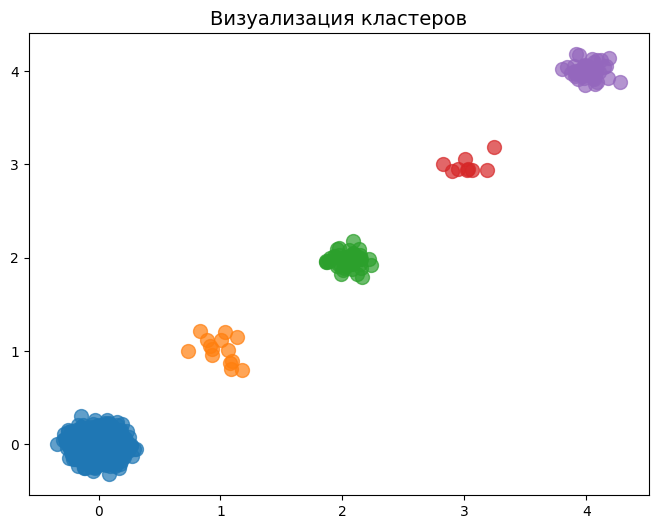

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for cluster_id in np.unique(labels_norm):
    n_artists = sum(labels_norm == cluster_id)
    x = np.random.normal(loc=cluster_id, scale=0.1, size=n_artists)
    y = np.random.normal(loc=cluster_id, scale=0.1, size=n_artists)
    plt.scatter(
        x, y,
        label=f'Cluster {cluster_id}',
        alpha=0.7,
        s=100
    )
plt.title('Визуализация кластеров', fontsize=14)
plt.show()

**Ответ:** график показывает каждый кластер как "облако" точек, сгруппированных вокруг условного центра. Расстояние между облаками — абстрактное, не привязано к реальным признакам, а размер облака — отражает количество исполнителей в кластере, что полезно.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

Text(0.5, 1.0, 'Визуализация кластеров по TSNE')

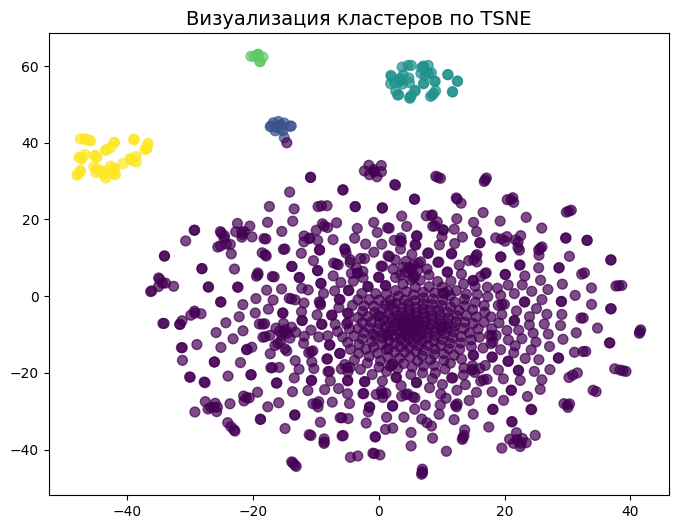

In [114]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=5,
    random_state=42
)

tsne_results = tsne.fit_transform(ratings_norm)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=labels_norm,          # Цвета по кластерам
    cmap='viridis',         # Цветовая карта
    alpha=0.7,              # Прозрачность
    s=50                    # Размер точек
)

plt.title('Визуализация кластеров по TSNE', fontsize=14)

Такая визуализация явно приятнее и точнее отражает локальные расстояния между близкими объектами.

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

Я не вижу смысла рассматривать более 10 кластеров, потому что до этого мы видели на примере, что 5 кластеров и то было многовато для данной выборки.

In [115]:
from sklearn.metrics import silhouette_score

cluster_range = range(2, 10)
silhouette_scores = []
ratings_norm.columns = ratings_norm.columns.astype(str)


for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(ratings_norm)
    silhouette_avg = silhouette_score(ratings_norm, cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"\nОптимальное количество кластеров: {optimal_clusters}")


Оптимальное количество кластеров: 2


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [116]:
kmeans_2 = KMeans(n_clusters=2, random_state=42).fit(features)
labels_2 = kmeans_2.labels_


for cluster_id in [0, 1]:
    print(f"\n Кластер {cluster_id} (размер: {sum(labels_2 == cluster_id)} исполнителей)")
    centroid = kmeans_2.cluster_centers_[cluster_id].reshape(1, -1)

    dist_matrix = cosine_distances(centroid, features)
    top_10_indices = np.argsort(dist_matrix[0])[:10]

    for i, idx in enumerate(top_10_indices, 1):
        print(f"{i}. {features.index[idx]}")


 Кластер 0 (размер: 898 исполнителей)
1. radiohead
2. deathcab for cutie
3. coldplay
4. sufjan stevens
5. the shins
6. the arcade fire
7. kanye west
8. modest mouse
9. the killers
10. belle and sebastian

 Кластер 1 (размер: 102 исполнителей)
1. radiohead
2. deathcab for cutie
3. red hot clili peppers
4. white stripes
5. the shins
6. coldplay
7. the killers
8. modest mouse
9. sufjan stevens
10. foo fighters


**Ответ:** Кластер 0 (898 исполнителей) – более широкий и разнородный, включает как инди/альтернативных артистов (Radiohead, Arcade Fire), так и поп-рок (Coldplay, The Killers) и даже хип-хоп (Kanye West).

Кластер 1 (102 исполнителя) – уже и более «гитарно-роковый», с акцентом на альтернативный рок 1990–2000-х (White Stripes, Foo Fighters, Red Hot Chili Peppers)

Сделайте t-SNE визуализацию полученной кластеризации.

Text(0.5, 1.0, 'Визуализация двух кластеров по TSNE')

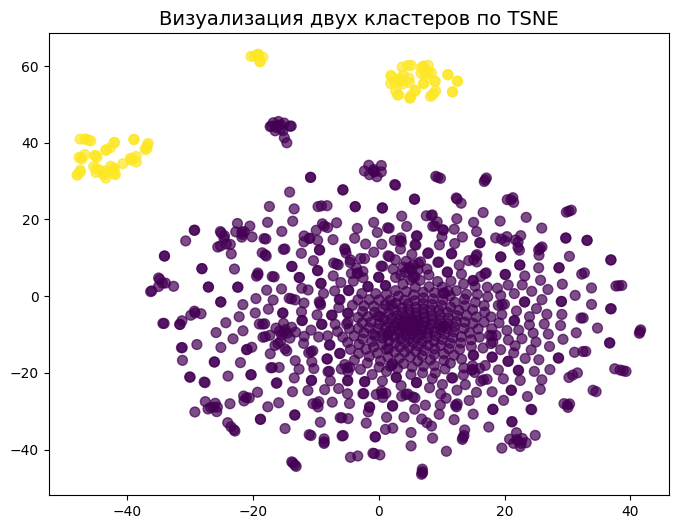

In [117]:
tsne_2 = TSNE(
    n_components=2,
    perplexity=2,
    random_state=42
)

tsne_2_results = tsne.fit_transform(ratings_norm)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    tsne_2_results[:, 0],
    tsne_2_results[:, 1],
    c=labels_2,
    cmap='viridis',
    alpha=0.7,
    s=50
)

plt.title('Визуализация двух кластеров по TSNE', fontsize=14)

**Ответ:** Тут олично видно разделение кластеров, также заметно, что первый кластер сильно больше второго.